In [1]:
import time

import onnxruntime
import onnx
import torch

import torch.nn as nn
from PIL import Image, ImageDraw
from transformers import RTDetrForObjectDetection, RTDetrImageProcessor


device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"

In [2]:
image_processor = RTDetrImageProcessor.from_pretrained("jadechoghari/RT-DETRv2")
rtdetrmodel = RTDetrForObjectDetection.from_pretrained("jadechoghari/RT-DETRv2")

In [ ]:
class Model(nn.Module):
    def __init__(self,) -> None:
        super().__init__()
        self.model = rtdetrmodel
        self.postprocessor = image_processor.post_process_object_detection

    def forward(self, images, orig_target_size):
        outputs = self.model(images)
        outputs = self.postprocessor(outputs, orig_target_size)
        return outputs

In [3]:
data = torch.rand(1, 3, 640, 640)
# size = torch.tensor([[640, 640]])
# model = Model()
# _ = model(data, size)

dynamic_axes = {
    'images': {0: 'N', },
    # 'orig_target_sizes': {0: 'N'}
}
torch.onnx.export(
    rtdetrmodel,
    data,
    # model,
    # (data, size),
    "rt-detr_model.onnx",
    # input_names=['images', 'orig_target_sizes'],
    # output_names=['labels', 'boxes', 'scores'],
    input_names=['images'],
    output_names=['outputs'],
    # input_names=["input"],
    # output_names=["output"],
    dynamic_axes=dynamic_axes,
    # export_params=True,
    opset_version=16,
    do_constant_folding=True
)

onnx_model = onnx.load("rt-detr_model.onnx")
onnx.checker.check_model(onnx_model)

c:\Users\User\anaconda3\envs\cv\Lib\site-packages\transformers\models\rt_detr\modeling_rt_detr_resnet.py:107: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if num_channels != self.num_channels:
c:\Users\User\anaconda3\envs\cv\Lib\site-packages\transformers\models\rt_detr\modeling_rt_detr.py:1311: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  grid_w = torch.arange(int(width), dtype=dtype, device=device)
c:\Users\User\anaconda3\envs\cv\Lib\site-packages\transformers\models\rt_detr\modeling_rt_detr.py:1312: TracerWarning: Converting a tensor to a Python i

In [36]:
# ort_session = onnxruntime.InferenceSession("rt-detr_model.onnx", providers=["CUDAExecutionProvider"])
ort_session = onnxruntime.InferenceSession("rt-detr_model.onnx", providers=["CPUExecutionProvider"])
print(onnxruntime.get_device())

GPU


In [39]:
img = Image.open("000000039769.jpg")
start = time.time()
input_tensor = image_processor(img, return_tensors="pt").to(device)
end = time.time()
print(f"image processor (pre): {end - start}")

image processor (pre): 0.012073755264282227


In [44]:
start = time.time()
# ort_inputs = {ort_session.get_inputs()[0].name: input_tensor}
ort_inputs = {'images': input_tensor["pixel_values"].cpu().numpy()}
ort_outs = ort_session.run(
    # output_names=['labels', 'boxes', 'scores'],
    output_names=None, 
    input_feed=ort_inputs
)
end = time.time()
print(f"model: {end - start}")

model: 0.08104991912841797


In [23]:
from dataclasses import dataclass

@dataclass
class DetrOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor

In [46]:
start = time.time()
detr_output = DetrOutput(logits = torch.from_numpy(ort_outs[0]).to("cuda"),
                         pred_boxes = torch.from_numpy(ort_outs[1]).to("cuda"))
results = image_processor.post_process_object_detection(detr_output, target_sizes=torch.tensor([img.size[::-1]]), threshold=0.3)
end = time.time()
print(f"image processor (post): {end - start}")

image processor (post): 0.001988649368286133


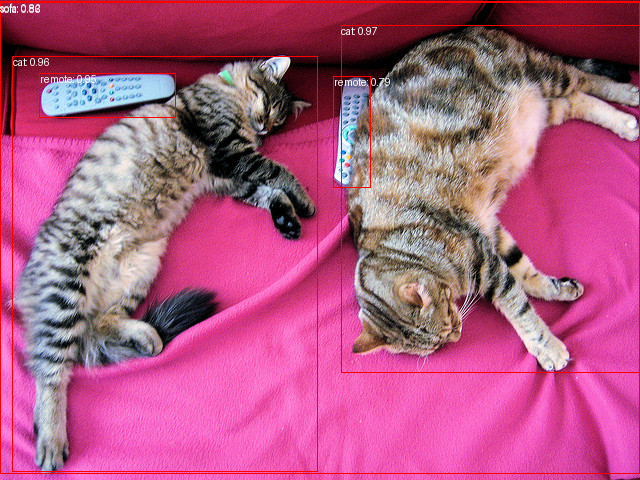

In [47]:
draw_img2 = img.copy()
draw = ImageDraw.Draw(draw_img2)

# labels, boxes, scores = output

for result in results:
    for score, label_id, box in zip(result["scores"], result["labels"], result["boxes"]):
        score, label = score.item(), label_id.item()
        box = [round(i, 2) for i in box.tolist()]
        if score > 0.5:
            draw.rectangle(box, fill=None, outline='red')
            draw.text((box[0], box[1]), f"{rtdetrmodel.config.id2label[label]}: {score:.2f}")

display(draw_img2)